# Lecture 10: Cavity-QED in the dispersive regime

Author: J. R. Johansson (robert@riken.jp), http://dml.riken.jp/~rob/

The latest version of this [IPython notebook](http://ipython.org/ipython-doc/dev/interactive/htmlnotebook.html) lecture is available at [http://github.com/jrjohansson/qutip-lectures](http://github.com/jrjohansson/qutip-lectures).

The other notebooks in this lecture series are indexed at [http://jrjohansson.github.com](http://jrjohansson.github.com).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from qutip import *

# Introduction

A qubit-resonator system can described by the Hamiltonian

$\displaystyle H = \omega_r a^\dagger a - \frac{1}{2} \omega_q \sigma_z + g (a^\dagger + a) \sigma_x$

where $\omega_r$ and $\omega_q$ are the the bare frequencies of the resonator and qubit, respectively, and where $g$ is the dipole interaction strength. 

The dispersive regime occurs when the resonator and qubit is far off resonance, $\Delta \gg g$, where $\Delta = \omega_r-\omega_q$ is the detuning between the resonator and the qubit (for example $\omega_r \gg \omega_q$).

In the dispersive regime the system can be described by an effective Hamiltonian on the form

$\displaystyle H = \omega_r a^\dagger a - \frac{1}{2}\omega_q \sigma_z + \chi (a^\dagger a  + 1/2) \sigma_z$

where $\chi = g^2/\Delta$ . We can view the last term as a correction of the resonator frequency that depends on the qubit state, or a correction to the qubit frequency that depends on the resonator state.

In a beautiful experiment by D. I. Schuster et al., the dispersive regime was used to resolving the photon number states of a microwave resonator by monitoring a qubit that was coupled to the resonator. This notebook shows how to simulate this kind of system numerically in QuTiP.

### References

 * [D. I. Schuster et al., Resolving photon number states in a superconducting circuit, Nature 445, 515 (2007)](http://dx.doi.org/10.1038/nature05461)

## Parameters

In [6]:
N = 20

wr = 2.0 * 2 * np.pi      # resonator frequency
wq = 3.0 * 2 * np.pi      # qubit frequency
chi = 0.025 * 2 * np.pi   # parameter in the dispersive hamiltonian

delta = abs(wr - wq)        # detuning
g = np.sqrt(delta * chi)  # coupling strength that is consistent with chi

In [8]:
# compare detuning and g, the first should be much larger than the second
delta/(2*np.pi), g/(2*np.pi)

(1.0, 0.15811388300841897)

In [9]:
# cavity operators
a = tensor(destroy(N), qeye(2))
nc = a.dag() * a
xc = a + a.dag()

# atomic operators
sm = tensor(qeye(N), destroy(2))
sz = tensor(qeye(N), sigmaz())
sx = tensor(qeye(N), sigmax())
nq = sm.dag() * sm
xq = sm + sm.dag()

I = tensor(qeye(N), qeye(2))

In [10]:
# dispersive hamiltonian
H = wr * (a.dag() * a + I/2.0) + (wq / 2.0) * sz + chi * (a.dag() * a + I/2) * sz

Try different initial state of the resonator, and see how the spectrum further down in the notebook reflects the photon distribution chosen here.

In [7]:
#psi0 = tensor(coherent(N, sqrt(6)), (basis(2,0)+basis(2,1)).unit())

In [8]:
#psi0 = tensor(thermal_dm(N, 3), ket2dm(basis(2,0)+basis(2,1))).unit()

In [12]:
psi0 = tensor(coherent(N, np.sqrt(4)), (basis(2,0)+basis(2,1)).unit())

## Time evolution

In [13]:
tlist = np.linspace(0, 250, 1000)

In [14]:
res = mesolve(H, psi0, tlist, [], [], options=Odeoptions(nsteps=5000))

### Excitation numbers

We can see that the systems do not exchange any energy, because of they are off resonance with each other.

In [15]:
nc_list = expect(nc, res.states)
nq_list = expect(nq, res.states)

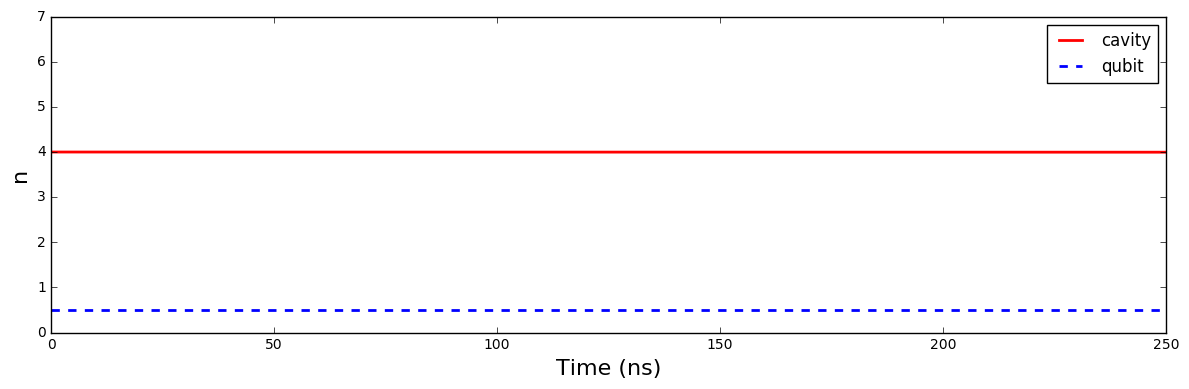

In [16]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))

ax.plot(tlist, nc_list, 'r', linewidth=2, label="cavity")
ax.plot(tlist, nq_list, 'b--', linewidth=2, label="qubit")
ax.set_ylim(0, 7)
ax.set_ylabel("n", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()

fig.tight_layout()

### Resonator quadrature

However, the quadratures of the resonator are oscillating rapidly.

In [17]:
xc_list = expect(xc, res.states)

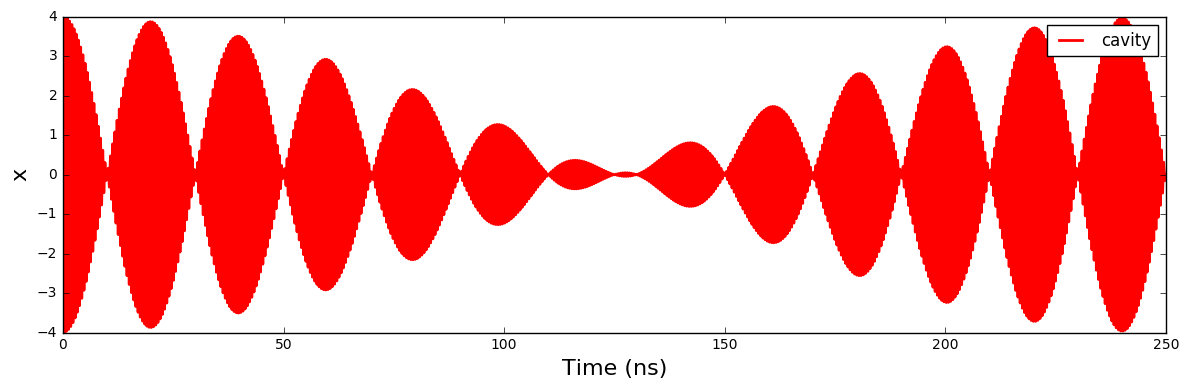

In [18]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))

ax.plot(tlist, xc_list, 'r', linewidth=2, label="cavity")
ax.set_ylabel("x", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()

fig.tight_layout()

### Correlation function for the resonator

In [19]:
tlist = np.linspace(0, 1000, 10000)

In [22]:
corr_vec = correlation_2op_2t(H, psi0, None, tlist, [], a.dag(), a)

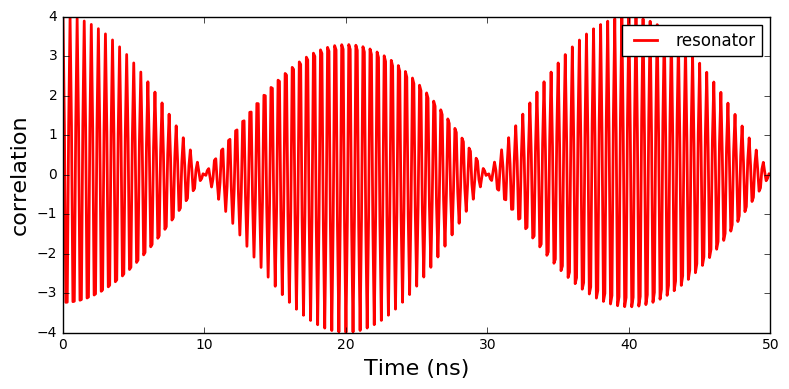

In [24]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,4))

ax.plot(tlist, np.real(corr_vec), 'r', linewidth=2, label="resonator")
ax.set_ylabel("correlation", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()
ax.set_xlim(0,50)
fig.tight_layout()

### Spectrum of the resonator

In [19]:
w, S = spectrum_correlation_fft(tlist, corr_vec)

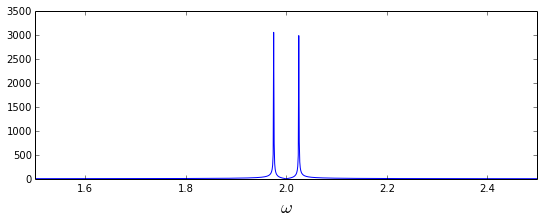

In [20]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(w / (2 * pi), abs(S))
ax.set_xlabel(r'$\omega$', fontsize=18)
ax.set_xlim(wr/(2*pi)-.5, wr/(2*pi)+.5);

Here we can see how the resonator peak is split and shiften up and down due to the superposition of 0 and 1 states of the qubit! We can also verify that the splitting is exactly $2\chi$, as expected:

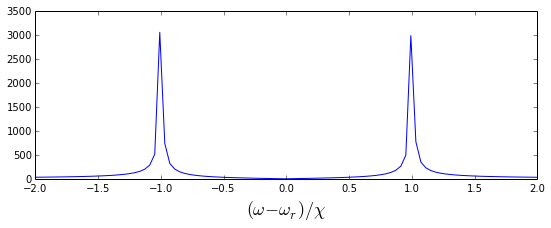

In [21]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot((w-wr)/chi, abs(S))
ax.set_xlabel(r'$(\omega-\omega_r)/\chi$', fontsize=18)
ax.set_xlim(-2,2);

### Correlation function of the qubit

In [22]:
corr_vec = correlation(H, psi0, None, tlist, [], sx, sx)

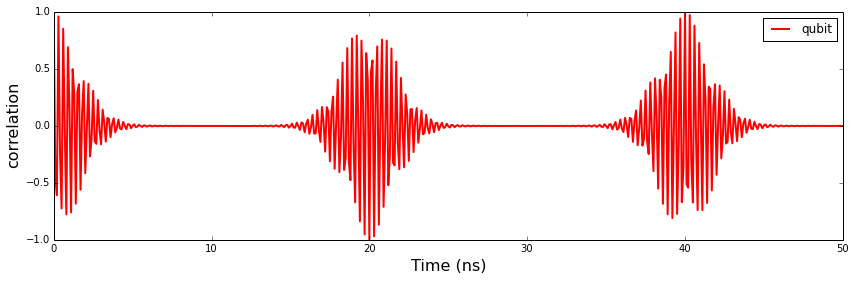

In [23]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))

ax.plot(tlist, real(corr_vec), 'r', linewidth=2, label="qubit")
ax.set_ylabel("correlation", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()
ax.set_xlim(0,50)
fig.tight_layout()

### Spectrum of the qubit

The spectrum of the qubit has an interesting structure: from it one can see the photon distribution in the resonator mode!

In [24]:
w, S = spectrum_correlation_fft(tlist, corr_vec)

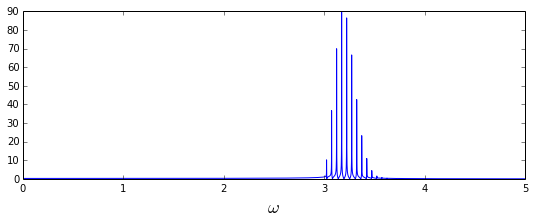

In [25]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(w / (2 * pi), abs(S))
ax.set_xlabel(r'$\omega$', fontsize=18)

It's a bit clearer if we shift the spectrum and scale it with $2\chi$

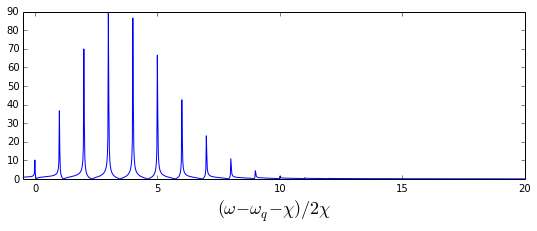

In [26]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot((w - wq - chi) / (2 * chi), abs(S))
ax.set_xlabel(r'$(\omega - \omega_q - \chi)/2\chi$', fontsize=18)
ax.set_xlim(-.5, N);

Compare to the cavity fock state distribution:

In [27]:
rho_cavity = ptrace(res.states[-1], 0)

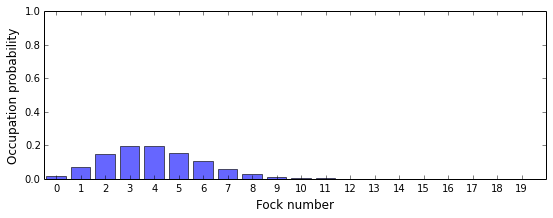

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, N)-.4, real(rho_cavity.diag()), color="blue", alpha=0.6)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, N)
axes.set_xticks(arange(0, N))
axes.set_xlabel('Fock number', fontsize=12)
axes.set_ylabel('Occupation probability', fontsize=12);

And if we look at the cavity wigner function we can see that after interacting dispersively with the qubit, the cavity is no longer in a coherent state, but in a superposition of coherent states.

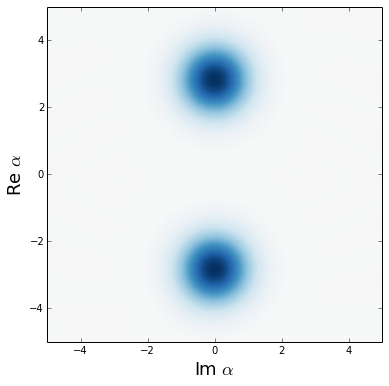

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(6,6))

xvec = np.linspace(-5,5,200)
W = wigner(rho_cavity, xvec, xvec)
wlim = abs(W).max()

axes.contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-wlim,wlim), cmap=plt.get_cmap('RdBu'))
axes.set_xlabel(r'Im $\alpha$', fontsize=18)
axes.set_ylabel(r'Re $\alpha$', fontsize=18);

### Software versions

In [31]:
from qutip.ipynbtools import version_table
version_table()